In [ ]:
# ===== INSTALLATION CELL =====
!pip install -q pandas numpy tensorflow matplotlib

In [ ]:
# ===== IMPORTS =====
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from typing import Tuple, List
from tensorflow import keras
layers = keras.layers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ===== CONFIGURATION =====
DATASET_PATH = "/content/drive/MyDrive/Dataset"
OUTPUT_PATH = "/content/drive/MyDrive/Output/OutputNCA"

In [ ]:
# Network params
SENSOR_DIM = 16  # V (sensor input)
ESTIMATION_DIM = 2  # E (x, y position estimate)
HIDDEN_DIM = 2  # H (hidden state)
NCA_HIDDEN_DIM = 32  # Hidden dimension for NCA update network
NUM_NCA_STEPS = 16  # Number of NCA iterations

# Training params
BATCH_SIZE = 32
LEARNING_RATE = 0.05
NUM_EPOCHS = 50


In [ ]:
# ===== DATA LOADING =====
class CenterDataset:
    def __init__(self,
                 dataset_path: str,
                 data_type: str = "Threshold20g",
                 sensor_file: str = "calibrated_sensor_data.csv",
                 center_file: str = "center_of_mass_estimate.csv",
                 output_data_type: str = "CAMERA"):
        self.dataset_path = Path(dataset_path)
        self.data_type_path = self.dataset_path / data_type
        self.sensor_file = sensor_file
        self.center_file = center_file
        self.output_data_type = output_data_type
        self.samples = self._load_samples()

    def _load_samples(self) -> List[Tuple[str, str]]:
        samples: List[Tuple[str, str]] = []
        if not self.data_type_path.exists():
            return samples
        for shape_dir in [d for d in self.data_type_path.iterdir() if d.is_dir()]:
            for recording_dir in [d for d in shape_dir.iterdir() if d.is_dir()]:
                sensor_file_path = recording_dir / self.sensor_file
                center_file_path = recording_dir / self.center_file
                if sensor_file_path.exists() and center_file_path.exists():
                    samples.append((str(sensor_file_path), str(center_file_path)))
        return samples

    def __len__(self) -> int:
        return len(self.samples)

    def _load_sensor(self, path: str) -> np.ndarray:
        try:
            df = pd.read_csv(path, usecols=range(1, 17))
            if df.shape[1] != 16:
                raise ValueError(f"Expected 16 sensor columns, got {df.shape[1]}")
            values = df.values.astype(np.float32)
            if values.ndim == 2 and values.shape[0] == 1:
                vec16 = values[0]
            else:
                vec16 = values.mean(axis=0)
            return vec16.reshape((1, 1, 16))
        except Exception:
            return np.zeros((1, 1, 16), dtype=np.float32)

    def _load_target(self, path: str) -> np.ndarray:
        try:
            df = pd.read_csv(path)
            if self.output_data_type not in df.columns:
                raise ValueError(f"{self.output_data_type} column not found in {path}")
            cam_vals = df[self.output_data_type].values.astype(np.float32)
            if cam_vals.size < 2:
                raise ValueError("Expected at least 2 rows for target")
            return cam_vals[:2]
        except Exception:
            return np.zeros((2,), dtype=np.float32)

    def to_tf_dataset(self,
                      batch_size: int = 32,
                      shuffle: bool = True,
                      seed: int = 42) -> tf.data.Dataset:
        if len(self.samples) == 0:
            raise ValueError("No paired samples found.")

        def _py_load(sensor_path, center_path):
            sensor_path = sensor_path.decode("utf-8")
            center_path = center_path.decode("utf-8")
            x = self._load_sensor(sensor_path)
            y = self._load_target(center_path)
            return x.astype(np.float32), y.astype(np.float32)

        def _tf_map(sensor_path, center_path):
            x, y = tf.numpy_function(_py_load, [sensor_path, center_path], [tf.float32, tf.float32])
            x.set_shape((1, 1, 16))
            y.set_shape((2,))
            return x, y

        sensors, centers = zip(*self.samples)
        ds = tf.data.Dataset.from_tensor_slices((list(sensors), list(centers)))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(self.samples), seed=seed, reshuffle_each_iteration=True)
        ds = ds.map(_tf_map, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds

def create_datasets(dataset_path: str,
                    data_type: str = "Threshold20g",
                    batch_size: int = 32,
                    train_split: float = 0.8,
                    val_split: float = 0.1,
                    test_split: float = 0.1,
                    seed: int = 42) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    dataset = CenterTFDataset(dataset_path, data_type)
    n = len(dataset)
    train_size = int(train_split * n)
    val_size = int(val_split * n)

    rng = np.random.default_rng(seed)
    indices = np.arange(n)
    rng.shuffle(indices)
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]

    samples = list(dataset.samples)
    train_samples = [samples[i] for i in train_idx.tolist()]
    val_samples = [samples[i] for i in val_idx.tolist()]
    test_samples = [samples[i] for i in test_idx.tolist()]

    def _build_from_samples(sample_list, shuffle: bool) -> tf.data.Dataset:
        tmp_ds = CenterTFDataset(dataset_path, data_type)
        tmp_ds.samples = list(sample_list)
        return tmp_ds.to_tf_dataset(batch_size=batch_size, shuffle=shuffle, seed=seed)

    return (
        _build_from_samples(train_samples, shuffle=True),
        _build_from_samples(val_samples, shuffle=False),
        _build_from_samples(test_samples, shuffle=False),
    )


In [ ]:
# ===== STATE STRUCTURE =====
class StateStructure:
    """
    State vector structure for NCA:
    - V: Sensor input
    - E: Estimation/prediction
    - H: Hidden channels
     """
    def __init__(self, sensor_dim: int, estimation_dim: int, hidden_dim: int):
        self.sensor_dim = sensor_dim  # V
        self.estimation_dim = estimation_dim  # E
        self.hidden_dim = hidden_dim  # H

        # Channel slices in state vector: [V, E, H]
        self.sensor_channels = slice(0, sensor_dim)
        self.estimation_channels = slice(sensor_dim, sensor_dim + estimation_dim)
        self.hidden_channels = slice(sensor_dim + estimation_dim,
                                     sensor_dim + estimation_dim + hidden_dim)

        # Total state dimension
        self.state_dim = sensor_dim + estimation_dim + hidden_dim

        # Output channels from NN
        self.out_dimension = estimation_dim + hidden_dim
        self.out_estimation_channels = slice(0, estimation_dim)
        self.out_hidden_channels = slice(estimation_dim, estimation_dim + hidden_dim)

In [ ]:
# ===== NCA MODEL =====
class NCA_CenterFinder(keras.Model):
    """
    Neural Cellular Automata for center finding.
    Processes sensor input through multiple update steps.
    Model inspired from https://github.com/nhbess/NCA-REAL/blob/main/NCAs/NCA.py
    """

    def __init__(self, state_structure: StateStructure,
                 nca_hidden_dim: int = 128,
                 num_steps: int = 5,
                 neighborhood: str = 'Chebyshev',
                 **kwargs):
        super().__init__(**kwargs)
        self.state_structure = state_structure
        self.state_dim = state_structure.state_dim
        self.out_dimension = state_structure.out_dimension
        self.num_steps = num_steps
        self.neighborhood = neighborhood
        self.nca_hidden_dim = nca_hidden_dim
        self._initialized = False # Track if we've initialized weights

        # Perceive layer: gathers neighborhood information
        self.perceive = layers.DepthwiseConv2D(
            kernel_size=3,
            padding="same",
            depth_multiplier=3,  # Identity + Sobel_x + Sobel_y
            use_bias=False,
            data_format="channels_last",
            name="perceive"
        )

        # Process layer: transforms perceptual inputs
        self.process = layers.Conv2D(
            filters=nca_hidden_dim,
            kernel_size=1,
            padding="valid",
            activation=None,
            data_format="channels_last",
            name="process"
        )

        self.activation = layers.ReLU(name="relu")

        # Output layer: generates updates for E and H
        self.output_layer = layers.Conv2D(
            filters=self.out_dimension,
            kernel_size=1,
            padding="valid",
            activation=None,
            data_format="channels_last",
            name="output"
        )

    def get_config(self):
        """Serialize configuration"""
        config = super().get_config()
        config.update({
            'state_structure': {
                'sensor_dim': self.state_structure.sensor_dim,
                'estimation_dim': self.state_structure.estimation_dim,
                'hidden_dim': self.state_structure.hidden_dim,
            },
            'nca_hidden_dim': self.nca_hidden_dim,
            'num_steps': self.num_steps,
            'neighborhood': self.neighborhood,
        })
        return config

    @classmethod
    def from_config(cls, config):
        """Deserialize from configuration"""
        state_struct_config = config.pop('state_structure')
        state_structure = StateStructure(
            sensor_dim=state_struct_config['sensor_dim'],
            estimation_dim=state_struct_config['estimation_dim'],
            hidden_dim=state_struct_config['hidden_dim']
        )
        return cls(state_structure=state_structure, **config)


    def _initialize_perceive_layer(self):
        """Initialize perceive layer with identity and Sobel filters"""
        if self._initialized:
            return


        # Identity filter
        I = np.outer([0, 1, 0], [0, 1, 0])
        # Sobel x filter
        Sx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0
        # Sobel y filter
        Sy = Sx.T

        # Stack filters: [identity, sobel_x, sobel_y]
        kernel = np.stack([I, Sx, Sy], axis=0)
        kernel = np.tile(kernel, [self.state_dim, 1, 1])

        # Apply neighborhood mask
        if self.neighborhood == 'Chebyshev':
            N = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
        elif self.neighborhood == 'Manhattan':
            N = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
        else:
            raise ValueError(f'Invalid neighborhood {self.neighborhood}')

        kernel = kernel * N.T
        kernel = kernel.reshape(self.state_dim, 3, 3, 3)
        kernel = kernel.transpose(1, 2, 0, 3)

        self.perceive.set_weights([kernel.astype(np.float32)])
        self.perceive.trainable = False

        # Initialize output layer for small residual updates
        output_weights = self.output_layer.get_weights()
        output_weights[0] = output_weights[0] * 0.0
        self.output_layer.set_weights(output_weights)

    def _single_step(self, input_state):
        """
        Single NCA update step.
        State: [V, E, H] -> Update: [ΔE, ΔH] -> New State: [V, E+ΔE, H+ΔH]
        """
        # Extract sensor values (V) - these will be preserved
        sensor_values = input_state[..., self.state_structure.sensor_channels]

        # Binary mask: which cells have sensor input
        sum_sensors = tf.reduce_sum(sensor_values, axis=-1, keepdims=True)  # float32
        has_sensor_input = tf.nn.relu(sum_sensors)  # float32
        has_sensor_input = tf.minimum(has_sensor_input, 1.0)  # float32
        #has_sensor_input = tf.maximum(tf.sign(sum_sensors), 0.0)  # float32; yields 0.0 or 1.0 //removed for easier conversion in tflite
        # Forward pass through NN
        x = self.perceive(input_state)
        x = self.process(x)
        x = self.activation(x)
        updates = self.output_layer(x)

        # Split updates into estimation and hidden components
        estimation_update = updates[..., self.state_structure.out_estimation_channels]
        hidden_update = updates[..., self.state_structure.out_hidden_channels]

        # Build full update vector [0 for V, ΔE, ΔH]
        batch_size = tf.shape(input_state)[0]
        height = tf.shape(input_state)[1]
        width = tf.shape(input_state)[2]

        update_vector = tf.concat([
            tf.zeros((batch_size, height, width, self.state_structure.sensor_dim)),
            estimation_update,
            hidden_update
        ], axis=-1)

        # Apply residual update
        new_state = input_state + update_vector

        # Restore sensor values and apply sensor mask to estimation
        estimation_part = new_state[..., self.state_structure.estimation_channels]
        hidden_part = new_state[..., self.state_structure.hidden_channels]

        # For cells without sensor input, set estimation to 0
        estimation_part = estimation_part * has_sensor_input

        # Reconstruct complete state
        new_state = tf.concat([
            sensor_values,
            estimation_part,
            hidden_part
        ], axis=-1)

        return new_state

    def call(self, sensor_input, training=False):
        """
        Process sensor input through NCA iterations.

        Args:
            sensor_input: Sensor data of shape (batch, 1, 1, 16)
            training: Whether in training mode

        Returns:
            Final estimation (batch, 2)
        """
        batch_size = tf.shape(sensor_input)[0]

        # Initialize state: [V, E, H]
        # V = sensor input, E = zeros, H = zeros
        initial_estimation = tf.zeros((batch_size, 1, 1, self.state_structure.estimation_dim))
        initial_hidden = tf.zeros((batch_size, 1, 1, self.state_structure.hidden_dim))

        state = tf.concat([sensor_input, initial_estimation, initial_hidden], axis=-1)

        # Run NCA for num_steps iterations
        for _ in range(self.num_steps):
            state = self._single_step(state)

        # Extract final estimation and flatten
        final_estimation = state[..., self.state_structure.estimation_channels]
        final_estimation = tf.reshape(final_estimation, (batch_size, self.state_structure.estimation_dim))

        return final_estimation


def build_nca_model(state_structure: StateStructure,
                    nca_hidden_dim: int = 128,
                    num_steps: int = 5) -> keras.Model:
    """Build NCA model """
    inputs = keras.Input(shape=(1, 1, state_structure.sensor_dim), dtype=tf.float32, name='sensor_input')

    nca = NCA_CenterFinder(state_structure, nca_hidden_dim, num_steps)
    outputs = nca(inputs)

    model = keras.Model(inputs, outputs, name="NCA_CenterFinder")
    return model


# ===== TRAINING FUNCTION =====
def train_nca_model():
    os.makedirs(OUTPUT_PATH, exist_ok=True)

    print("Loading datasets...")
    train_ds, val_ds, test_ds = create_datasets(
        dataset_path=DATASET_PATH,
        data_type="Threshold20g",
        batch_size=BATCH_SIZE,
        train_split=0.7,
        val_split=0.15,
        test_split=0.15,
        seed=42,
    )

    print("Building NCA model...")
    state_struct = StateStructure(SENSOR_DIM, ESTIMATION_DIM, HIDDEN_DIM)
    model = build_nca_model(state_struct, NCA_HIDDEN_DIM, NUM_NCA_STEPS)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
    )

    model.summary()

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    ckpt_path = os.path.join(OUTPUT_PATH, f"nca_centre_regressor_{timestamp}.keras")

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=ckpt_path,
            save_best_only=True,
            monitor="val_loss",
            mode="min",
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=5, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        ),
    ]

    print("Starting training...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=NUM_EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )

    # Evaluate
    print("\nEvaluating on test set...")
    eval_res = model.evaluate(test_ds, verbose=1)
    print("Test results:", dict(zip(model.metrics_names, eval_res)))

    # Plot curves
    plot_path = os.path.join(OUTPUT_PATH, f"nca_training_curves_{timestamp}.png")
    plot_history(history, plot_path)
    print(f"Saved training curves to {plot_path}")

    # Save final model
    final_path = os.path.join(OUTPUT_PATH, f"nca_centre_regressor_final_{timestamp}.keras")
    model.save(final_path)
    print(f"Saved model to {final_path}")

    return model, history, timestamp

In [ ]:
# ===== PLOTTING UTILITIES =====
def plot_history(history: tf.keras.callbacks.History, out_path: str) -> None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.subplot(1, 2, 2)
    if "mae" in history.history:
        plt.plot(history.history["mae"], label="Train MAE")
    if "val_mae" in history.history:
        plt.plot(history.history["val_mae"], label="Val MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.title("Training and Validation MAE")

    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

def plot_results(y_true: np.ndarray, y_pred: np.ndarray, out_dir: str, tag: str) -> None:
    os.makedirs(out_dir, exist_ok=True)
    err = y_pred - y_true
    l2_err = np.linalg.norm(err, axis=1)

    # Scatter plots true vs pred
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true[:, 0], y_pred[:, 0], s=8, alpha=0.6)
    lims = [min(y_true[:, 0].min(), y_pred[:, 0].min()), max(y_true[:, 0].max(), y_pred[:, 0].max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel('True X')
    plt.ylabel('Pred X')
    plt.title('True vs Pred X')

    plt.subplot(1, 2, 2)
    plt.scatter(y_true[:, 1], y_pred[:, 1], s=8, alpha=0.6)
    lims = [min(y_true[:, 1].min(), y_pred[:, 1].min()), max(y_true[:, 1].max(), y_pred[:, 1].max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel('True Y')
    plt.ylabel('Pred Y')
    plt.title('True vs Pred Y')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'scatter_true_vs_pred_{tag}.png'))
    plt.show()

    # Error histogram
    plt.figure(figsize=(6, 4))
    plt.hist(l2_err, bins=30, alpha=0.8)
    plt.xlabel('L2 error')
    plt.ylabel('Count')
    plt.title('L2 Error Distribution')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'error_hist_{tag}.png'))
    plt.show()

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    err = y_pred - y_true
    mae = np.mean(np.abs(err), axis=0)
    rmse = np.sqrt(np.mean(err ** 2, axis=0))
    mae_total = float(np.mean(np.abs(err)))
    rmse_total = float(np.sqrt(np.mean(err ** 2)))
    return {
        "mae_x": float(mae[0]),
        "mae_y": float(mae[1]),
        "rmse_x": float(rmse[0]),
        "rmse_y": float(rmse[1]),
        "mae": mae_total,
        "rmse": rmse_total,
    }


Loading datasets...
Building NCA model...


Model: "NCA_CenterFinder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sensor_input (InputLayer)       │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nca__center_finder_7            │ (None, 2)              │         2,624 │
│ (NCA_CenterFinder)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,624 (10.25 KB)

 Trainable params: 2,624 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - loss: 2718.4260 - mae: 33.0474 - val_loss: 413.8632 - val_mae: 16.6122 - learning_rate: 0.0500
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 484.0214 - mae: 17.6968 - val_loss: 414.3772 - val_mae: 16.6832 - learning_rate: 0.0500
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - loss: 365.0083 - mae: 15.4969 - val_loss: 309.6633 - val_mae: 14.8715 - learning_rate: 0.0500
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - loss: 263.9286 - mae: 13.3418 - val_loss: 231.0419 - val_mae: 12.2954 - learning_rate: 0.0500
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - loss: 240.4201 - mae: 12.0982 - val_loss: 258.0297 - val_mae: 13.4598 - learning_rate: 0.0500
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - loss: 230.0151 - mae: 12.2400 - val_loss: 224.1623 - val_mae: 12.0704 - learning_rate: 0.0500
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - loss: 225.9879 - mae: 11.9971 - val

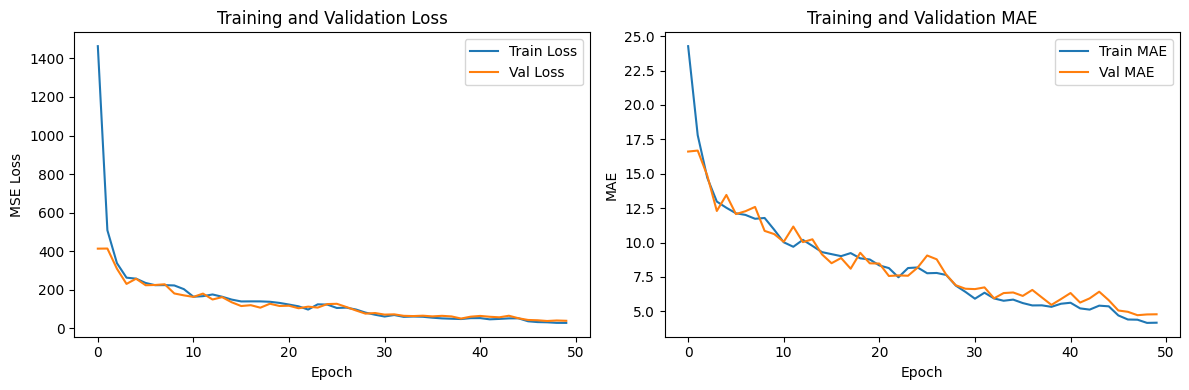

Saved training curves to /content/drive/MyDrive/Output/OutputNCA/nca_training_curves_2025-11-20_10-06.png
Saved model to /content/drive/MyDrive/Output/OutputNCA/nca_centre_regressor_final_2025-11-20_10-06.keras


In [ ]:
model, history, timestamp = train_nca_model()

In [ ]:
def evaluate_model(model_path: str, data_type: str = "Threshold20g", batch_size: int = 32):
    print(f"Loading model from {model_path}...")

    # Build datasets with the same split ratios used in training
    train_ds, val_ds, test_ds = create_datasets(
        dataset_path=DATASET_PATH,
        data_type=data_type,
        batch_size=batch_size,
        train_split=0.7,
        val_split=0.15,
        test_split=0.15,
        seed=42,
    )

    # Reconstruct test sample list deterministically
    full_ds = CenterDataset(DATASET_PATH, data_type)
    n = len(full_ds)
    train_size = int(0.7 * n)
    val_size = int(0.15 * n)
    rng = np.random.default_rng(42)
    indices = np.arange(n)
    rng.shuffle(indices)
    test_idx = indices[train_size + val_size:]
    test_samples = [full_ds.samples[i] for i in test_idx.tolist()]

    print(f"Loaded {len(test_samples)} test samples")


    # pass custom objects
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={'NCA_CenterFinder': NCA_CenterFinder}
    )

    preds = model.predict(test_ds, verbose=1)

    # Load ground-truth targets
    def load_target(path: str) -> np.ndarray:
        try:
            df = pd.read_csv(path)
            vals = df[full_ds.output_data_type].values.astype(np.float32)
            return vals[:2]
        except Exception:
            return np.zeros((2,), dtype=np.float32)

    y_true = np.stack([load_target(center) for _, center in test_samples], axis=0)
    y_pred = preds.astype(np.float32)

    metrics = compute_metrics(y_true, y_pred)
    print("Overall metrics:", metrics)

    # Save per-sample predictions
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    csv_path = os.path.join(OUTPUT_PATH, f"nca_predictions_{timestamp}.csv")
    rows = []
    for (sensor_path, center_path), yp, yt in zip(test_samples, y_pred, y_true):
        err = yp - yt
        rows.append({
            'sensor_path': sensor_path,
            'center_path': center_path,
            'true_x': float(yt[0]),
            'true_y': float(yt[1]),
            'pred_x': float(yp[0]),
            'pred_y': float(yp[1]),
            'err_x': float(err[0]),
            'err_y': float(err[1]),
            'err_l2': float(np.linalg.norm(err)),
        })
    pd.DataFrame(rows).to_csv(csv_path, index=False)
    print(f"Saved predictions to {csv_path}")

    # Plots
    plot_results(y_true, y_pred, OUTPUT_PATH, tag=timestamp)
    print(f"Saved plots to {OUTPUT_PATH}")

    return metrics, y_true, y_pred

Loading model from /content/drive/MyDrive/Output/OutputNCA/nca_centre_regressor_final_2025-11-20_10-06.keras...
Loaded 122 test samples
4/4 ━━━━━━━━━━━━━━━━━━━━ 101s 24s/step
Overall metrics: {'mae_x': 5.215069770812988, 'mae_y': 5.32138204574585, 'rmse_x': 7.507290840148926, 'rmse_y': 6.812542915344238, 'mae': 5.26822566986084, 'rmse': 7.168339252471924}
Saved predictions to /content/drive/MyDrive/Output/OutputNCA/nca_predictions_2025-11-28_11-55.csv


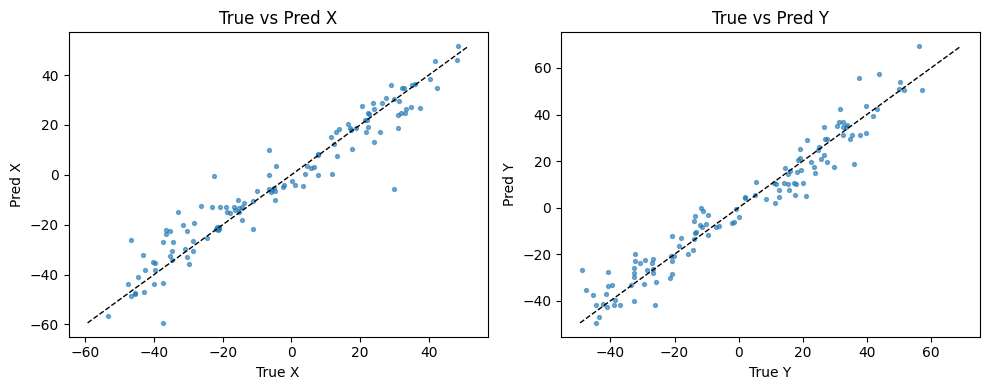

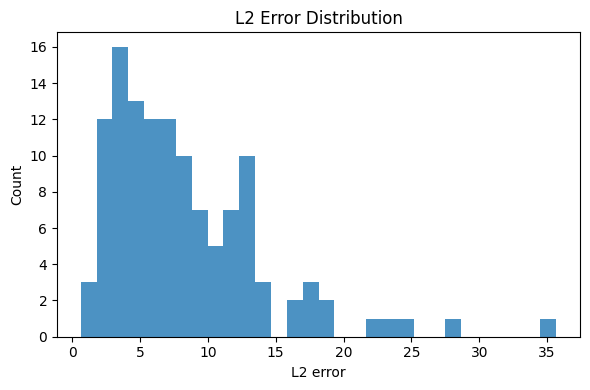

Saved plots to /content/drive/MyDrive/Output/OutputNCA


In [ ]:
# Evaluate a saved model
metrics, y_true, y_pred = evaluate_model('/content/drive/MyDrive/Output/OutputNCA/nca_centre_regressor_final_2025-11-20_10-06.keras')

In [ ]:
tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8

<OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8: 'EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8'>

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
model = tf.keras.models.load_model("//content/drive/MyDrive/Output/OutputNCA/nca_centre_regressor_final_2025-11-20_10-06.keras",
                                   custom_objects={'NCA_CenterFinder': NCA_CenterFinder} )



# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

def representative_dataset():
    count = 0
    # create_datasets returns (train_ds, val_ds, test_ds)
    # Correctly unpack the three datasets into variables
    train_ds, _, _ = create_datasets(DATASET_PATH, "Threshold20g", BATCH_SIZE,
                                            0.8, 0.1, 0.1, 42)
    # Iterate over the batches from the training dataset
    # Each element from train_ds is a tuple (batch_sensor_data, batch_target_data)
    for batch_sensor_data, _ in train_ds:
        for i in range(batch_sensor_data.shape[0]):
            if count >= 100:
                return # Stop generating after 100 samples
            sample = batch_sensor_data[i:i+1]  # Get a single sample with shape (1, 1, 1, 16)
            yield [sample] # Yield it as a list, as expected by TFLiteConverter
            count += 1

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

# converter._experimental_disable_per_channel = True  # Use per-tensor quantization

tflite_model = converter.convert()
# Save the model to disk
open("nca_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("nca_model.tflite")
print("Model is %d bytes" % basic_model_size)

Saved artifact at '/tmp/tmp2ql616x_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 1, 16), dtype=tf.float32, name='sensor_input')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139883720102096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139883720102864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139883720102480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139883720103440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139883720104016: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model is 108696 bytes


In [ ]:
# Verify
interpreter = tf.lite.Interpreter(model_path="nca_model.tflite")
interpreter.allocate_tensors()

# Get input details
input_details = interpreter.get_input_details()
print("Input quantization params:")
print("Scale:", input_details[0]['quantization'][0])
print("Zero point:", input_details[0]['quantization'][1])
output_details = interpreter.get_output_details()
print("Output quantization params:")
print("Scale:", output_details[0]['quantization'][0])
print("Zero point:", output_details[0]['quantization'][1])

Input quantization params:
Scale: 0.9795611500740051
Zero point: -77
Output quantization params:
Scale: 0.402652770280838
Zero point: -2


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
interpreter = tf.lite.Interpreter(model_path="nca_model.tflite")
interpreter.allocate_tensors()

# Get all tensors
tensors = interpreter.get_tensor_details()

print(f"Total tensors: {len(tensors)}")
print("\nTensor breakdown:")

total_size = 0
for t in tensors:
    if t['shape'] is not None and len(t['shape']) > 0:
        size = np.prod(t['shape'])
        dtype_size = 1 if t['dtype'] == np.int8 else 4  # bytes
        tensor_bytes = size * dtype_size
        total_size += tensor_bytes

        if tensor_bytes > 1000:  # Only show tensors > 1KB
            print(f"  {t['name']}: {t['shape']} ({t['dtype']}) = {tensor_bytes/1024:.2f} KB")

print(f"\nEstimated tensor data: {total_size/1024:.2f} KB")
print(f"Actual file size: {os.path.getsize('nca_model.tflite')/1024:.2f} KB")
print(f"Overhead: {(os.path.getsize('nca_model.tflite') - total_size)/1024:.2f} KB")

Total tensors: 410

Tensor breakdown:
  tfl.pseudo_qconst49: [32  1  1 60] (<class 'numpy.int8'>) = 1.88 KB

Estimated tensor data: 12.37 KB
Actual file size: 106.15 KB
Overhead: 93.78 KB


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:

# Analyze tensor types
const_tensors = 0
variable_tensors = 0
activation_tensors = 0

for t in tensors:
    if 'const' in t['name'].lower():
        const_tensors += 1
    elif t['shape'] is not None and len(t['shape']) > 0:
        if np.prod(t['shape']) > 0:
            variable_tensors += 1

print(f"Total tensors: {len(tensors)}")
print(f"Constant tensors: {const_tensors}")
print(f"Variable tensors: {variable_tensors}")
print(f"\nTensor name samples:")
for i, t in enumerate(tensors[:20]):  # First 20
    size = np.prod(t['shape']) if t['shape'] is not None else 0
    print(f"  {t['name']}: shape={t['shape']}, size={size} elements")

Total tensors: 410
Constant tensors: 97
Variable tensors: 296

Tensor name samples:
  serving_default_sensor_input:0: shape=[ 1  1  1 16], size=16 elements
  arith.constant: shape=[1], size=1 elements
  arith.constant1: shape=[1], size=1 elements
  arith.constant2: shape=[], size=1 elements
  arith.constant3: shape=[], size=1 elements
  arith.constant4: shape=[], size=1 elements
  arith.constant5: shape=[4], size=4 elements
  arith.constant6: shape=[4], size=4 elements
  arith.constant7: shape=[4], size=4 elements
  arith.constant8: shape=[4], size=4 elements
  arith.constant9: shape=[4], size=4 elements
  arith.constant10: shape=[4], size=4 elements
  arith.constant11: shape=[4], size=4 elements
  arith.constant12: shape=[], size=1 elements
  tfl.pseudo_qconst: shape=[], size=1 elements
  tfl.pseudo_qconst1: shape=[], size=1 elements
  tfl.pseudo_qconst2: shape=[], size=1 elements
  tfl.pseudo_qconst3: shape=[], size=1 elements
  tfl.pseudo_qconst4: shape=[], size=1 elements
  tfl.pse

In [ ]:
# Get operator details (undocumented but works)
op_details = interpreter._get_ops_details()

print(f"\nTotal operations: {len(op_details)}")

# Count operation types
from collections import Counter
op_types = []
for op in op_details:
    # Try to get operator name
    try:
        op_types.append(op['op_name'])
    except:
        pass

if op_types:
    op_counts = Counter(op_types)
    print("\nOperation breakdown:")
    for op_type, count in op_counts.most_common():
        print(f"  {op_type}: {count}")


Total operations: 329

Operation breakdown:
  STRIDED_SLICE: 98
  CONCATENATION: 33
  CONV_2D: 32
  PACK: 18
  SHAPE: 17
  FILL: 17
  DELEGATE: 17
  DEPTHWISE_CONV_2D: 16
  ADD: 16
  SUM: 16
  RELU: 16
  MINIMUM: 16
  MUL: 16
  RESHAPE: 1


In [ ]:
for i, op in enumerate(op_details):
    if 'DELEGATE' in str(op.get('op_name', '')):
        print(f"Delegate op {i}: {op}")

Delegate op 4: {'index': 4, 'op_name': 'DELEGATE', 'inputs': array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), 'outputs': array([11], dtype=int32), 'operand_types': [<class 'numpy.int8'>, <class 'numpy.int32'>, <class 'numpy.int32'>, <class 'numpy.int8'>, <class 'numpy.int32'>, <class 'numpy.int8'>, <class 'numpy.int32'>, <class 'numpy.int8'>], 'result_types': [<class 'numpy.int8'>]}


In [ ]:
interpreter = tf.lite.Interpreter(model_path="nca_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("INPUT_SCALE:", input_details[0]['quantization'][0])
print("INPUT_ZERO_POINT:", input_details[0]['quantization'][1])
print("OUTPUT_SCALE:", output_details[0]['quantization'][0])
print("OUTPUT_ZERO_POINT:", output_details[0]['quantization'][1])

INPUT_SCALE: 1.5434545278549194
INPUT_ZERO_POINT: -43
OUTPUT_SCALE: 1.5434545278549194
OUTPUT_ZERO_POINT: -43


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:

interpreter = tf.lite.Interpreter(model_path="nca_model.tflite")
interpreter.allocate_tensors()

# Check for non-quantized or custom ops
tensor_details = interpreter.get_tensor_details()

print("Checking for potential issues...")
for i, details in enumerate(tensor_details):
    # Look for unusually large tensors
    if 'shape' in details and details['shape'] is not None:
        size = 1
        for dim in details['shape']:
            if dim > 0:
                size *= dim
        if size > 1000:  # Flag large tensors
            print(f"Large tensor {i}: {details['name']}, shape: {details['shape']}, size: {size}")

# Get op codes
print("\nOperators in model:")
for op in interpreter._get_ops_details():
    print(f"  - {op}")

Checking for potential issues...
Large tensor 63: tfl.pseudo_qconst49, shape: [32  1  1 60], size: 1920

Operators in model:
  - {'index': 0, 'op_name': 'SHAPE', 'inputs': array([0], dtype=int32), 'outputs': array([98], dtype=int32), 'operand_types': [<class 'numpy.int8'>], 'result_types': [<class 'numpy.int32'>]}
  - {'index': 1, 'op_name': 'STRIDED_SLICE', 'inputs': array([98,  1,  2,  2], dtype=int32), 'outputs': array([99], dtype=int32), 'operand_types': [<class 'numpy.int32'>, <class 'numpy.int32'>, <class 'numpy.int32'>, <class 'numpy.int32'>], 'result_types': [<class 'numpy.int32'>]}
  - {'index': 2, 'op_name': 'PACK', 'inputs': array([99,  3], dtype=int32), 'outputs': array([100], dtype=int32), 'operand_types': [<class 'numpy.int32'>, <class 'numpy.int32'>], 'result_types': [<class 'numpy.int32'>]}
  - {'index': 3, 'op_name': 'PACK', 'inputs': array([99,  4,  4,  3], dtype=int32), 'outputs': array([101], dtype=int32), 'operand_types': [<class 'numpy.int32'>, <class 'numpy.int32

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat nca_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

In [ ]:
import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 89,426 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
